# Loading the data

In [ ]:
import pandas as pd
import numpy as np

import torch
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.calibration import LabelEncoder
from torch.utils.data import DataLoader, Dataset

# set seed 
seed = 0
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [140]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')

In [141]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Columns: 635 entries, num__budget to category
dtypes: float64(634), object(1)
memory usage: 42.6+ MB
None
   num__budget  num__revenue  num__popularity  num__runtime  num__vote_count  \
0     4.757463      1.005269         0.425819      0.448734         1.716450   
1     2.894642      1.159981         0.366180     -0.230573         1.636140   
2     3.826052      2.100421         0.503760      0.739865         1.420090   
3     2.628524      0.670763         0.183190     -0.230573         1.375134   
4     1.510832      0.743000         0.159881     -0.085007         0.961366   

   num__release_year  num__release_month  cat__original_language_ar  \
0           0.483259           -0.241059                        0.0   
1           0.605583           -0.533445                        0.0   
2           0.789068           -0.241059                        0.0   
3           0.727906            0.343713               

In [142]:
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])

# NN

In [143]:
X = df.drop('category', axis=1)
Y = df['category']

In [144]:
print(X.shape)

(8784, 634)


In [145]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [146]:
# Create a custom Dataset class
class MovieDataset(Dataset):
    def __init__(self, features, labels):
        # Convert features to a NumPy array if it's a DataFrame
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()  # Convert DataFrame to NumPy array
        
        self.X = torch.tensor(features, dtype=torch.float32)  # Convert features to tensor
        self.y = torch.tensor(labels, dtype=torch.long)       # Convert labels to tensor

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Assuming X_train and Y_train are your features and labels DataFrames
# Convert Y_train to a NumPy array if it's also a DataFrame
if isinstance(Y_train, pd.Series):
    Y_train = Y_train.to_numpy()

if isinstance(Y_test, pd.Series):
    Y_test = Y_test.to_numpy()

# Create Dataset objects
train_dataset = MovieDataset(X_train, Y_train)
test_dataset = MovieDataset(X_test, Y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [147]:
# Define the neural network
class MovieClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MovieClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(128, 64)            # Third hidden layer with 32 neurons
        self.fc3 = nn.Linear(64, 16)            # Fourth hidden layer with 16 neurons
        self.output = nn.Linear(16, num_classes) # Output layer

        # Activation function
        self.relu = nn.ReLU()
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.output(x)  # Output layer (logits)
        return x
    

In [148]:
input_size = X_train.shape[1]  # Number of input features
num_classes = len(np.unique(Y_train))  # Number of classes in the target
model = MovieClassifier(input_size, num_classes)

# Set the device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True, eps=1e-8) 

# Training loop
num_epochs = 50  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 0.8141
Epoch [2/50], Loss: 0.8528
Epoch [3/50], Loss: 0.7664
Epoch [4/50], Loss: 0.8081
Epoch [5/50], Loss: 0.6065
Epoch [6/50], Loss: 0.7334
Epoch [7/50], Loss: 0.5150
Epoch [8/50], Loss: 0.6798
Epoch [9/50], Loss: 0.4019
Epoch [10/50], Loss: 0.5939
Epoch [11/50], Loss: 0.5825
Epoch [12/50], Loss: 0.4636
Epoch [13/50], Loss: 0.3067
Epoch [14/50], Loss: 0.2199
Epoch [15/50], Loss: 0.4701
Epoch [16/50], Loss: 0.4900
Epoch [17/50], Loss: 0.5629
Epoch [18/50], Loss: 0.3425
Epoch [19/50], Loss: 0.8815
Epoch [20/50], Loss: 0.5380
Epoch [21/50], Loss: 0.2283
Epoch [22/50], Loss: 0.5244
Epoch [23/50], Loss: 0.5503
Epoch [24/50], Loss: 0.2671
Epoch [25/50], Loss: 0.1462
Epoch [26/50], Loss: 0.5602
Epoch [27/50], Loss: 0.2736
Epoch [28/50], Loss: 0.4314
Epoch [29/50], Loss: 0.1810
Epoch [30/50], Loss: 0.0616
Epoch [31/50], Loss: 0.2267
Epoch [32/50], Loss: 0.2434
Epoch [33/50], Loss: 0.2183
Epoch [34/50], Loss: 0.3147
Epoch [35/50], Loss: 0.2421
Epoch [36/50], Loss: 0.3964
E

In [151]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()



In [152]:
# Print accuracy of the model
from sklearn.metrics import accuracy_score
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy_score(y_true, y_pred)

0.6778599886169607

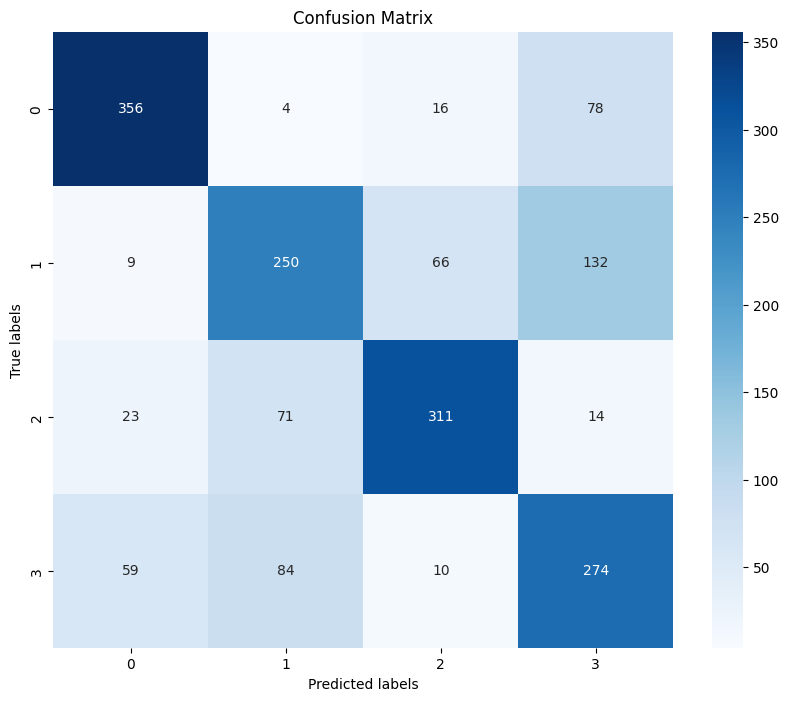

In [153]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [154]:
from sklearn.tree import DecisionTreeClassifier, export_text


surrogate_model = DecisionTreeClassifier(max_depth=10)  # Control complexity with max_depth
surrogate_model.fit(X_test, y_pred)

# Print the rules
tree_rules = export_text(surrogate_model, feature_names=df.columns[:-1].tolist())
print(tree_rules)

|--- num__vote_count <= -0.46
|   |--- num__runtime <= 0.62
|   |   |--- num__vote_count <= -0.51
|   |   |   |--- production_companies__bbcfilms <= 0.50
|   |   |   |   |--- genres__music <= 0.50
|   |   |   |   |   |--- overview__tries <= 0.53
|   |   |   |   |   |   |--- genres__family <= 0.50
|   |   |   |   |   |   |   |--- num__popularity <= -0.01
|   |   |   |   |   |   |   |   |--- production_countries__austria <= 0.50
|   |   |   |   |   |   |   |   |   |--- tagline__men <= 0.36
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- tagline__men >  0.36
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- production_countries__austria >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- num__popularity >  -0.01
|   |   |   |   |   |   |   |   |--- genres__mystery <= 0.50
|   |   |   |   |   |   |   |   |   |--- production_countries__united <= 0.50
|   |   |   |  

# Feature importances on DL

In [160]:
def train_and_evaluate(X_train, Y_train, X_test, Y_test, num_epochs=10):
    input_size = X_train.shape[1]  # Number of input features
    model = MovieClassifier(input_size, num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True, eps=1e-8)

    # Create data loaders for training
    train_tensor = torch.FloatTensor(X_train.values)
    train_labels_tensor = torch.LongTensor(Y_train.values)
    train_dataset = torch.utils.data.TensorDataset(train_tensor, train_labels_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on the test set
    model.eval()
    test_tensor = torch.FloatTensor(X_test.values)
    test_labels_tensor = torch.LongTensor(Y_test.values)
    test_dataset = torch.utils.data.TensorDataset(test_tensor, test_labels_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    y_pred = []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.cpu().numpy().tolist()

    return accuracy_score(Y_test, y_pred)

In [ ]:

# Calculate baseline accuracy
baseline_accuracy = train_and_evaluate(X_train, Y_train, X_test, Y_test)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

# Feature importance calculation
importances = {}

# Drop features that start with 'num' or 'cat' one at a time
for feature in X.columns:
    if feature.startswith('num') or feature.startswith('cat'):
        X_train_dropped = X_train.drop(feature, axis=1)
        X_test_dropped = X_test.drop(feature, axis=1)
        
        accuracy_dropped = train_and_evaluate(X_train_dropped, Y_train, X_test_dropped, Y_test)
        importances[feature] = baseline_accuracy - accuracy_dropped  # Importance is the drop in accuracy


groups = ['cast', 'director', 'production_companies', 'overview', 'tagline', 'production_countries', 'genres']

# Drop features one group at a time
for group in groups:
    features_to_drop = [feature for feature in X.columns if feature.startswith(group)]
    X_train_dropped = X_train.drop(features_to_drop, axis=1)
    X_test_dropped = X_test.drop(features_to_drop, axis=1)

    accuracy_dropped = train_and_evaluate(X_train_dropped, Y_train, X_test_dropped, Y_test)
    importances[group] = baseline_accuracy - accuracy_dropped  # Importance is the drop in accuracy

# Convert to a more interpretable format (e.g., DataFrame)
import pandas as pd
importance_df = pd.DataFrame(importances.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


Baseline Accuracy: 0.6739
                      Feature  Importance
4             num__vote_count    0.056346
52                     genres    0.026750
5           num__release_year    0.018213
8   cat__original_language_bn    0.010245
3                num__runtime    0.010245
0                 num__budget    0.009676
20  cat__original_language_fr    0.008537
33  cat__original_language_pl    0.007399
47                   director    0.006261
19  cat__original_language_fi    0.006261
44  cat__original_language_zh    0.005692
42  cat__original_language_tr    0.005122
7   cat__original_language_ar    0.005122
6          num__release_month    0.003415
10  cat__original_language_cn    0.003415
24  cat__original_language_id    0.003415
31  cat__original_language_nl    0.002846
25  cat__original_language_it    0.002846
51       production_countries    0.001138
28  cat__original_language_la    0.001138
26  cat__original_language_ja    0.000569
48       production_companies    0.000000
46      

In [162]:
# Drop columns with negative importance if they exist
columns_to_drop = importance_df[importance_df['Importance'] < 0]['Feature'].tolist()
X_columns = X.columns.tolist()
# keep columns that are not in columns_to_drop or that dont start with a column to drop
columns_to_keep = [col for col in X_columns if col not in columns_to_drop and not any(col.startswith(drop_col) for drop_col in columns_to_drop)]
X_train_filtered = X_train[columns_to_keep]
X_test_filtered = X_test[columns_to_keep]

In [163]:
train_and_evaluate(X_train_filtered, Y_train, X_test_filtered, Y_test, 50)

0.6852589641434262